# Movie Recommendation System using SVD (Detailed)

This notebook is a professional, end-to-end project for building a movie recommendation system using the MovieLens 100K dataset and an SVD (matrix factorization) model via the `surprise` library. It includes EDA, preprocessing, model training, hyperparameter tuning, latent-factor interpretation, exporting results, and conclusions.

### Notebook structure
1. Setup & imports
2. SVD theory
3. Load & inspect data
4. Preprocessing
5. Exploratory Data Analysis (optimized)
6. Prepare data for Surprise SVD
7. Train baseline SVD model
8. Hyperparameter tuning (GridSearchCV)
9. Latent-factor (feature) interpretation
10. Generate Top-N recommendations
11. Export predictions & model
12. Insights & next steps


## 1. Setup & Imports

This cell installs (if necessary) and imports required packages. If you run this in Colab, execute the first block to ensure dependencies.

In [ ]:
#run this cell if numpy is not compatible and restart session
!pip install numpy==1.26.4 --force-reinstall




  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires num

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 6.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2544627 sha256=80da7698646e4affa18f1094dc8eaeb107777ad884650ccd2ace99d0dd39a1eb
  Stored in directory: /root/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, GridSearchCV

# Display settings
pd.set_option("display.max_columns", 20)
sns.set(style="whitegrid", palette="pastel")

print("Libraries imported successfully.")


Libraries imported successfully.


## 2. Singular Value Decomposition (SVD)

**Concept Recap:**
SVD decomposes a user-item rating matrix `R` into three matrices:

\[
R \approx U \Sigma V^T
\]

- **U:** User feature matrix  
- **Σ:** Diagonal matrix of singular values (importance)  
- **Vᵀ:** Movie feature matrix  

This allows us to **approximate missing ratings** and **find latent relationships** between users and movies.


In [ ]:
# Example of SVD in NumPy (Concept Demo)
from numpy.linalg import svd

R = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [0, 0, 5, 4],
    [2, 1, 3, 0]
])

U, sigma, Vt = svd(R, full_matrices=False)

print("U shape:", U.shape)
print("Sigma shape:", sigma.shape)
print("Vt shape:", Vt.shape)

# Approximate Reconstruction
R_hat = np.dot(np.dot(U, np.diag(sigma)), Vt)
pd.DataFrame(np.round(R_hat, 2))



U shape: (5, 4)
Sigma shape: (4,)
Vt shape: (4, 4)


,0,1,2,3
0,5.0,3.0,0.0,1.0
1,4.0,0.0,0.0,1.0
2,1.0,1.0,0.0,5.0
3,0.0,-0.0,5.0,4.0
4,2.0,1.0,3.0,0.0


## 3. Load & Inspect Data

Load the MovieLens 100K core files (`u.data`, `u.item`, `u.user`).

In [ ]:

# Load files
ratings = pd.read_csv('u.data', sep='\t', names=['user_id','item_id','rating','timestamp'])
movies = pd.read_csv('u.item', sep='|', encoding='ISO-8859-1',
                     names=['movie_id','title','release_date','video_release_date','IMDb_URL',
                            'unknown','Action','Adventure','Animation',"Children's",'Comedy','Crime',
                            'Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery',
                            'Romance','Sci-Fi','Thriller','War','Western'])
users = pd.read_csv('u.user', sep='|', names=['user_id','age','gender','occupation','zip_code'])

print('ratings shape:', ratings.shape)
print('movies shape:', movies.shape)
print('users shape:', users.shape)

ratings.head()


ratings shape: (53154, 4)
movies shape: (1682, 24)
users shape: (943, 5)


,user_id,item_id,rating,timestamp
0,196,242,3.0,881250949.0
1,186,302,3.0,891717742.0
2,22,377,1.0,878887116.0
3,244,51,2.0,880606923.0
4,166,346,1.0,886397596.0


## 4. Preprocessing

Basic cleaning and merges for EDA and downstream tasks.

In [ ]:
# Convert timestamp to datetime for analysis
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

# Merge small preview for EDA
merged = ratings.merge(movies[['movie_id','title']], left_on='item_id', right_on='movie_id', how='left')
merged = merged.merge(users, on='user_id', how='left')

print('Merged preview:')
merged.head()


Merged preview:


,user_id,item_id,rating,timestamp,movie_id,title,age,gender,occupation,zip_code
0,196,242,3.0,1997-12-04 15:55:49,242,Kolya (1996),49,M,writer,55105
1,186,302,3.0,1998-04-04 19:22:22,302,L.A. Confidential (1997),39,F,executive,00000
2,22,377,1.0,1997-11-07 07:18:36,377,Heavyweights (1994),25,M,writer,40206
3,244,51,2.0,1997-11-27 05:02:03,51,Legends of the Fall (1994),28,M,technician,80525
4,166,346,1.0,1998-02-02 05:33:16,346,Jackie Brown (1997),47,M,educator,55113


## 5. Exploratory Data Analysis (optimized)

This section focuses on high-value EDA items: ratings distribution, popular movies, user activity, genre distribution, and temporal patterns.

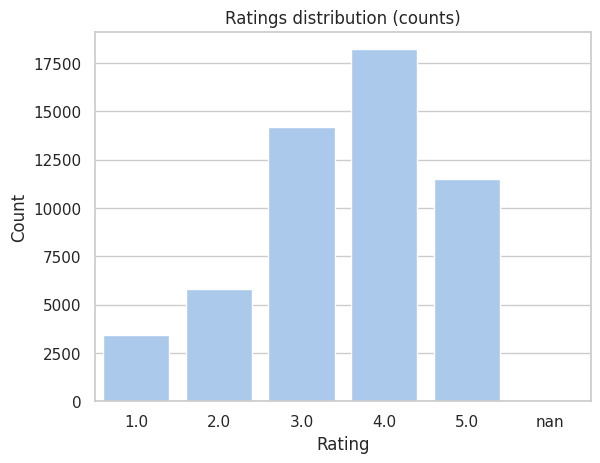

Users summary (count of ratings):


,0
count,801.000000
mean,66.359551
std,74.692440
min,1.000000
25%,18.000000
50%,38.000000
75%,89.000000
max,534.000000


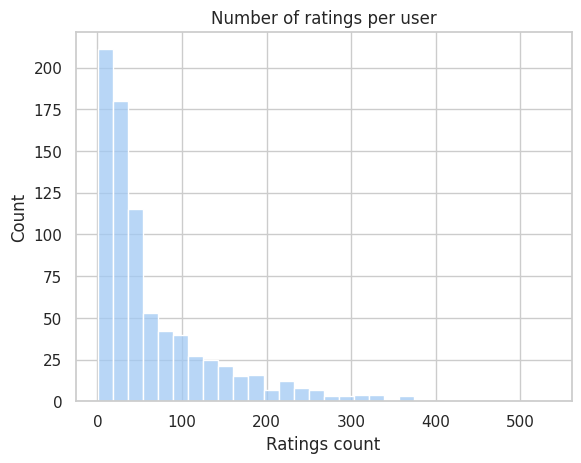

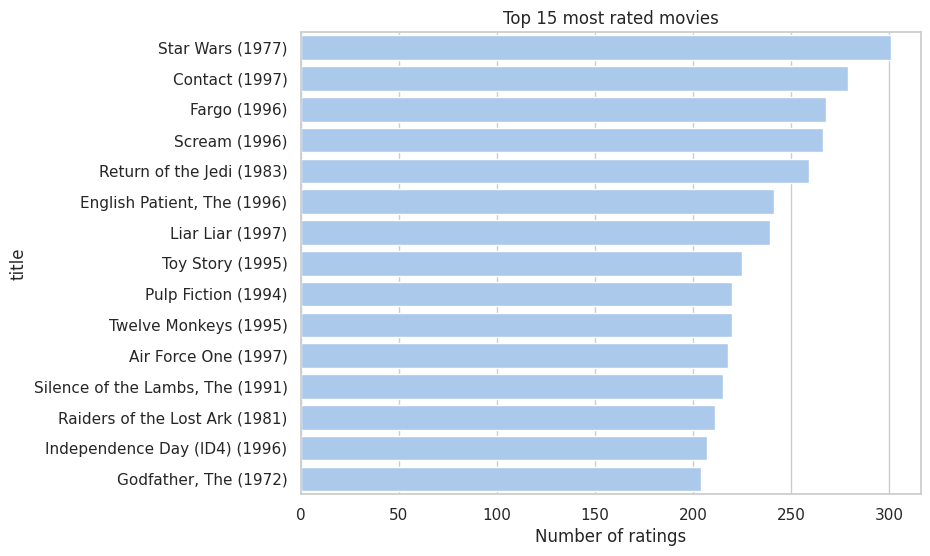

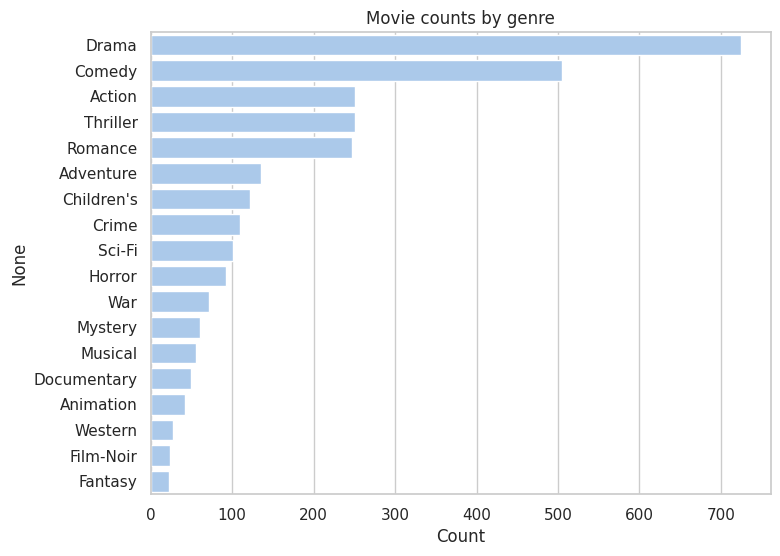

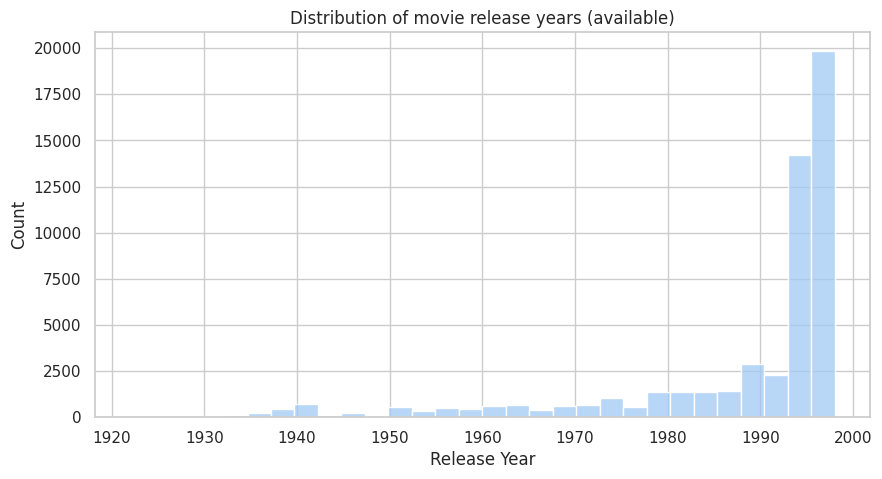

In [ ]:
# Ratings distribution
import matplotlib.ticker as mtick

plt.figure()
sns.countplot(x='rating', data=ratings, order=sorted(ratings['rating'].unique()))
plt.title('Ratings distribution (counts)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Ratings per user (activity)
user_activity = ratings.groupby('user_id').size().sort_values(ascending=False)
print('Users summary (count of ratings):')
display(user_activity.describe())

plt.figure()
sns.histplot(user_activity, bins=30, kde=False)
plt.title('Number of ratings per user')
plt.xlabel('Ratings count')
plt.show()

# Most rated movies
movie_counts = merged.groupby('title').size().sort_values(ascending=False).head(15)
plt.figure(figsize=(8,6))
sns.barplot(x=movie_counts.values, y=movie_counts.index)
plt.title('Top 15 most rated movies')
plt.xlabel('Number of ratings')
plt.show()

# Genre distribution (sum of genre flags)
genre_cols = ['Action','Adventure','Animation',"Children's",'Comedy','Crime','Documentary','Drama','Fantasy',
              'Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']

genre_counts = movies[genre_cols].sum().sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title('Movie counts by genre')
plt.xlabel('Count')
plt.show()

# Temporal analysis: ratings per year (by movie release year if available)
def extract_year(x):
    try:
        return int(str(x).split('-')[-1]) if pd.notna(x) and '-' in str(x) else np.nan
    except:
        return np.nan

movies['release_year'] = movies['release_date'].apply(lambda x: str(x).split('-')[-1] if pd.notna(x) and x!= '\\' else np.nan)
movies['release_year'] = pd.to_numeric(movies['release_year'], errors='coerce')

merged2 = merged.merge(movies[['movie_id','release_year']], left_on='item_id', right_on='movie_id', how='left')
plt.figure(figsize=(10,5))
sns.histplot(merged2['release_year'].dropna(), bins=30, kde=False)
plt.title('Distribution of movie release years (available)')
plt.xlabel('Release Year')
plt.show()


## 6. Prepare data for Surprise SVD

We will use Surprise's `Dataset` and `Reader`. We'll keep a reproducible train/test split and demonstrate both a simple split and full cross-validation.

In [ ]:
# Surprise Reader
from surprise import Reader, Dataset
reader = Reader(line_format='user item rating timestamp', sep='\t', rating_scale=(1,5))
data = Dataset.load_from_file('u.data', reader=reader)

# Use 80/20 split
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
print('Trainset n_users, n_items:', trainset.n_users, trainset.n_items)


Trainset n_users, n_items: 943 1651


## 7. Train baseline SVD model

Train a baseline SVD (default params) and evaluate with RMSE/MAE.

In [ ]:
# Baseline SVD
from surprise import SVD
svd = SVD(random_state=42)
svd.fit(trainset)
predictions = svd.test(testset)

# Evaluate
print('Evaluation on test set:')
rmse_val = accuracy.rmse(predictions, verbose=True)
mae_val = accuracy.mae(predictions, verbose=True)


Evaluation on test set:
RMSE: 0.9352
MAE:  0.7375


## 8. Hyperparameter tuning (GridSearchCV)

Use Surprise's `GridSearchCV` to find optimal `n_factors`, `lr_all`, and `reg_all`.

In [ ]:
# Grid search for SVD hyperparameters
param_grid = {'n_factors': [20, 50, 100],
              'lr_all': [0.002, 0.005, 0.01],
              'reg_all': [0.02, 0.05, 0.1]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=1, joblib_verbose=0)
gs.fit(data)

# Best parameters and score
print('Best RMSE score:', gs.best_score['rmse'])
print('Best params:', gs.best_params['rmse'])

# Train best estimator on full trainset split (train/test created earlier)
best_params = gs.best_params['rmse']
svd_tuned = SVD(n_factors=best_params['n_factors'], lr_all=best_params['lr_all'], reg_all=best_params['reg_all'], random_state=42)
svd_tuned.fit(trainset)
predictions_tuned = svd_tuned.test(testset)
print('\nTuned model evaluation:')
accuracy.rmse(predictions_tuned)
accuracy.mae(predictions_tuned)


Best RMSE score: 0.9282155180907
Best params: {'n_factors': 100, 'lr_all': 0.01, 'reg_all': 0.1}

Tuned model evaluation:
RMSE: 0.9196
MAE:  0.7275


0.7275226602685625

## 9. Latent-factor interpretation (feature analysis)

SVD produces latent user and item vectors (`pu` and `qi`). We can inspect item latent factors to interpret what each latent dimension captures by listing top movies for some factors.

In [ ]:
# Access item (movie) factors
qi = svd_tuned.qi  # item factors
pu = svd_tuned.pu  # user factors

n_factors = qi.shape[1]
print('Item factors shape:', qi.shape)

# Build table of movie_id -> factor vector index in Surprise internal id mapping
movie_factors = []
for raw_id in movies['movie_id'].astype(str).values:
    try:
        inner = svd_tuned.trainset.to_inner_iid(raw_id)
        vec = qi[inner]
        movie_factors.append((raw_id, vec))
    except Exception:
        continue

# For interpretability, list top movies for first 6 latent factors
top_k = 8
for f in range(min(6, n_factors)):
    movies_with_score = [(int(mid), vec[f]) for (mid, vec) in movie_factors]
    movies_with_score.sort(key=lambda x: x[1], reverse=True)
    top_movies_ids = [m for (m, s) in movies_with_score[:top_k]]
    top_titles = movies[movies['movie_id'].isin(top_movies_ids)][['movie_id','title']].drop_duplicates().set_index('movie_id').loc[top_movies_ids]['title'].values
    print(f"\nTop movies for latent factor #{f} (highest values):\n" + '\n'.join([f"{i+1}. {t}" for i,t in enumerate(top_titles)]))


Item factors shape: (1651, 100)

Top movies for latent factor #0 (highest values):
1. Steel (1997)
2. Romper Stomper (1992)
3. Beans of Egypt, Maine, The (1994)
4. Ghost in the Shell (Kokaku kidotai) (1995)
5. Kull the Conqueror (1997)
6. Small Faces (1995)
7. Boys in Venice (1996)
8. Midnight in the Garden of Good and Evil (1997)

Top movies for latent factor #1 (highest values):
1. Congo (1995)
2. Guilty as Sin (1993)
3. Love! Valour! Compassion! (1997)
4. B*A*P*S (1997)
5. Fire Down Below (1997)
6. Inspector General, The (1949)
7. Twisted (1996)
8. Full Speed (1996)

Top movies for latent factor #2 (highest values):
1. Ballad of Narayama, The (Narayama Bushiko) (1958)
2. Herbie Rides Again (1974)
3. The Deadly Cure (1996)
4. Shadow Conspiracy (1997)
5. Chasers (1994)
6. Van, The (1996)
7. Open Season (1996)
8. Blood Beach (1981)

Top movies for latent factor #3 (highest values):
1. Fifth Element, The (1997)
2. Event Horizon (1997)
3. I Know What You Did Last Summer (1997)
4. Simple 

## 10. Generate Top-N Recommendations

Generate Top-N recommended movies per user using the tuned model.

In [ ]:
def get_top_n(predictions, n=5):
    top_n = {}
    for uid, iid, true_r, est, _ in predictions:
        uid = int(uid)
        iid = int(iid)
        top_n.setdefault(uid, [])
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

# Create predictions for all user-item pairs not in trainset
anti_testset = trainset.build_anti_testset()
full_preds = svd_tuned.test(anti_testset)
top_n = get_top_n(full_preds, n=10)

# Show sample user's top 10 recommendations
sample_user = 50
if sample_user in top_n:
    recs = top_n[sample_user]
    rec_titles = [movies[movies['movie_id']==iid]['title'].values[0] for iid, _ in recs]
    print(f"Top 10 recommendations for user {sample_user}:\n" + '\n'.join([f"{i+1}. {t}" for i,t in enumerate(rec_titles)]))
else:
    print('Sample user not found in recommendations (maybe indexing difference).')


Top 10 recommendations for user 50:
1. Paths of Glory (1957)
2. Third Man, The (1949)
3. Casablanca (1942)
4. Pather Panchali (1955)
5. Wrong Trousers, The (1993)
6. Star Wars (1977)
7. Shawshank Redemption, The (1994)
8. Schindler's List (1993)
9. Close Shave, A (1995)
10. Rear Window (1954)


## 11. Export predictions & model

Export predictions to CSV and save tuned model parameters.

In [ ]:
# Export test predictions (true vs predicted)
pred_df = pd.DataFrame([(int(p.uid), int(p.iid), p.r_ui, p.est) for p in predictions_tuned],
                       columns=['user_id','movie_id','true_rating','predicted_rating'])
pred_df.to_csv('svd_test_predictions.csv', index=False)
print('Saved svd_test_predictions.csv')

# Export top-n recommendations to CSV (one row per user with list of movie ids)
topn_rows = []
for uid, recs in top_n.items():
    movie_ids = [str(m) for m,_ in recs]
    topn_rows.append({'user_id': uid, 'recommended_movie_ids': '|'.join(movie_ids)})
pd.DataFrame(topn_rows).to_csv('topn_recommendations.csv', index=False)
print('Saved topn_recommendations.csv')


Saved svd_test_predictions.csv
Saved topn_recommendations.csv


## 12. Insights & Next Steps

**Key insights:**

- Ratings are concentrated in the 3-4 range — typical of implicit positive bias.
- Popular genres and movies emerge clearly from EDA; these can be used to build hybrid recommenders.
- SVD (matrix factorization) captures latent factors; inspecting top movies per factor gives interpretability clues.

**Next steps & improvements:**

- Perform more extensive hyperparameter search (e.g., randomized search over broader space).
- Add temporal dynamics (timestamps) and biases for time-aware recommendations.
- Combine content-based features (genres, release year) to build a hybrid model.
- Create a lightweight API to serve Top-N recommendations (Flask/FastAPI) and a simple front-end.
